In [1]:
import pandas as pd
import numpy as np

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# load dataset
data = read_csv('energydata_complete.csv', header=0, index_col=0)
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [26]:
# convert series to supervised data
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    print(agg.shape)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
methods = ["VAR","Linear","SVM"]
stat_methods = ["VAR"]
ml_methods = ["Linear","SVM","LSTM"]
MSE = {}
MAE = {}
for i in range(0,len(stat_methods)):
    MSE[stat_methods[i]]=0.0
    MAE[stat_methods[i]]=0.0
for i in range(0,len(ml_methods)):
    MSE[ml_methods[i]]=0.0
    MAE[ml_methods[i]]=0.0
print(MSE)

{'VAR': 0.0, 'Linear': 0.0, 'SVM': 0.0, 'LSTM': 0.0}


In [7]:
import matplotlib.pyplot as plt 

def plot(y1,y2,title):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    # naming the x axis 
    plt.xlabel('x - axis') 
    # naming the y axis 
    plt.ylabel('Appliance energy') 
    # giving a title to my graph 
    plt.title(title) 
    # show a legend on the plot 
    plt.legend() 
    # function to show the plot 
    plt.show() 

3947


C:\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


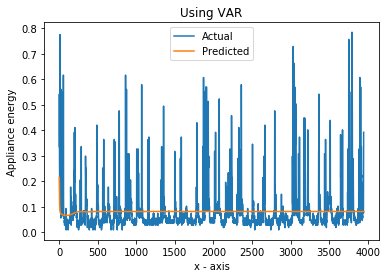

{'VAR': 0.007211959691707641, 'Linear': 0.0, 'SVM': 0.0, 'LSTM': 0.0}
{'VAR': 0.0485715465229016, 'Linear': 0.0, 'SVM': 0.0, 'LSTM': 0.0}


In [8]:
from statsmodels.tsa.vector_ar.var_model import VAR
def statistic_methods(data):
    #creating the train and validation set
    train = data[:int(0.8*(len(data)))]
    test = data[int(0.8*(len(data))):]
    print(len(test[:,0]))
    #fit the VAR model
    model = VAR(endog=train)
    model_fit = model.fit()
    prediction = model_fit.forecast(model_fit.y, steps=len(test))
    MAE['VAR'] = mean_absolute_error(prediction[:,0], test[:,0])
    MSE['VAR'] = mean_squared_error(prediction[:,0], test[:,0])
    plot(test[:,0],prediction[:,0],'Using VAR')
    #fit the VARMA model
    """model = VARMAX(train, order=(1, 1))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    MAE['VARMA'] = mean_absolute_error(prediction[0], test[0])
    MSE['VARMA'] = mean_squared_error(prediction[0], test[0])
    """
statistic_methods(scaled)
print(MSE)
print(MAE)

(19735, 98)
   var1(t-2)  var1(t-1)  var2(t-3)  var2(t-2)  var2(t-1)  var3(t-2)  \
3   0.046729   0.037383   0.428571   0.428571   0.428571   0.327349   
4   0.037383   0.037383   0.428571   0.428571   0.571429   0.327349   
5   0.037383   0.046729   0.428571   0.571429   0.571429   0.327349   
6   0.046729   0.037383   0.571429   0.571429   0.571429   0.327349   
7   0.037383   0.046729   0.571429   0.571429   0.714286   0.327349   

   var3(t-1)  var4(t-3)  var4(t-2)  var4(t-1)    ...     var19(t)  var20(t)  \
3   0.327349   0.566187   0.541326   0.530502    ...     0.219563  0.671909   
4   0.327349   0.541326   0.530502   0.524080    ...     0.219563  0.671909   
5   0.327349   0.530502   0.524080   0.531419    ...     0.219563  0.667356   
6   0.327349   0.524080   0.531419   0.522980    ...     0.219563  0.667356   
7   0.327349   0.531419   0.522980   0.515824    ...     0.219563  0.667356   

   var21(t)  var22(t)  var23(t)  var24(t)  var25(t)  var26(t)  var27(t)  \
3  0.361736

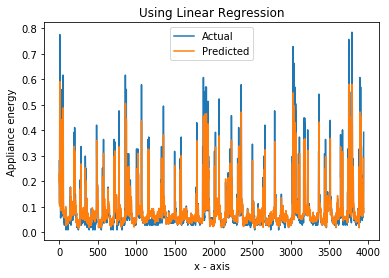

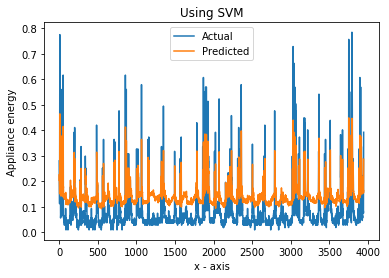

{'VAR': 0.007211959691707641, 'Linear': 0.0032754058, 'SVM': 0.00757482115522261, 'LSTM': 0.0}
{'VAR': 0.0485715465229016, 'Linear': 0.027351558, 'SVM': 0.07872774685449496, 'LSTM': 0.0}


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
def ml_methods(data):
    n_lag = []
    n_features = 28
    n_obs = 0
    for i in range(0,n_features):
        if i%2==0:
            n_lag.append(2)
            n_obs+=2
        else:
            n_obs+=3
            n_lag.append(3)
    reframed = series_to_supervised(data, n_lag, 1)
    print(reframed.head())
    # split into train and test sets
    values = reframed.values
    n_train = int(0.8*(len(data)))
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    # Fit Linear Regression 
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    MAE['Linear'] = mean_absolute_error(prediction, test_y)
    MSE['Linear'] = mean_squared_error(prediction, test_y)
    plot(test_y,prediction,'Using Linear Regression')
    # Fit SVM model
    model = SVR(kernel='rbf')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    MAE['SVM'] = mean_absolute_error(prediction, test_y)
    MSE['SVM'] = mean_squared_error(prediction, test_y)
    plot(test_y,prediction,'Using SVM')
ml_methods(scaled)
print(MSE)
print(MAE)

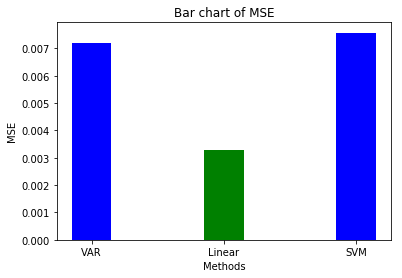

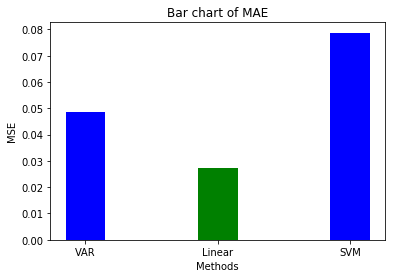

In [29]:

import matplotlib.pyplot as plt
 


performance = []
for i in range(0,3):
    performance.append(MSE[methods[i]])
    

# x-coordinates of left sides of bars  
left = [1, 2, 3] 
# plotting a bar chart 
plt.bar(left, performance, tick_label = methods, width = 0.3, color = ['blue', 'green']) 
  
# naming the x-axis 
plt.xlabel('Methods') 
# naming the y-axis 
plt.ylabel('MSE') 
# plot title 
plt.title('Bar chart of MSE') 
  
# function to show the plot 
plt.show() 





for i in range(0,3):
    performance[i]=MAE[methods[i]]
# plotting a bar chart 
plt.bar(left, performance, tick_label = methods, width = 0.3, color = ['blue', 'green']) 
  
# naming the x-axis 
plt.xlabel('Methods') 
# naming the y-axis 
plt.ylabel('MSE') 
# plot title 
plt.title('Bar chart of MAE') 
  
# function to show the plot 
plt.show() 

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
n_lag = 1
n_features = 28
reframed = series_to_supervised(scaled, n_lag, 1)
#print(reframed.head())
# split into train and test sets
values = reframed.values
n_train = int(0.8*(len(data)))
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
n_obs = n_lag * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, len(train_X), train_y.shape)
# feature extraction
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(train_X, train_y)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
# summarize selected features
features = fit.transform(train_X)
print(features)
    

TypeError: 'int' object is not subscriptable